This notebook will go through the pipeline for normalizing an fMRI dataset into the MNI template space.

Importing modules

In [2]:
%matplotlib inline
import os, shutil, errno
import sklearn.metrics
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from nipype.interfaces import fsl, ants
from nipype.caching import Memory

mem = Memory(base_dir='.')

datadir='/home/vagrant/data'
assert os.path.exists(datadir)

print('Using data from',datadir)

results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
def force_symlink(file1, file2):
    try:
        os.symlink(file1, file2)
    except OSError as e:
        if e.errno == errno.EEXIST:
            os.remove(file2)
            os.symlink(file1, file2)

Using data from /home/vagrant/data


Setting up variables

In [9]:
subject='ses014'  
# note - we have to use the anatomy from a different session'
anat_subject='ses018'
bolddir=os.path.join(datadir,'ds031/sub00001',subject,
        'functional')
fmapdir=os.path.join(datadir,'ds031/sub00001',subject,
        'fieldmap')

meanbold_unwarped_file=os.path.join(results_dir, "meanbold_unwarped.nii.gz")
meanbold=os.path.join(results_dir, "meanbold.nii.gz")
fmapmagdiff=os.path.join(fmapdir, "sub00001_ses014_001_magdiff.nii.gz")
fmapphasediff=os.path.join(fmapdir, "sub00001_ses014_001_phasediff.nii.gz")
fmapmag=os.path.join(fmapdir, "sub00001_ses014_001_magnitude.nii.gz")
fmapmagbrain=os.path.join(results_dir, "fmapmagbrain.nii.gz")
fmap=os.path.join(results_dir, "fieldmap.nii.gz")
boldfile=os.path.join(bolddir,
    'sub00001_ses014_task002_run001_bold.nii.gz')
anatomydir=os.path.join(datadir,'ds031/sub00001',anat_subject,
        'anatomy')
t1file=os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')

In [4]:
datadir

'/home/vagrant/data'

## Bias field correction of the T1

In [5]:
bias_field_correcton = mem.cache(ants.N4BiasFieldCorrection)
bias_field_correcton_results = bias_field_correcton(input_image = t1file, 
                                                    dimension = 3,
                                                    save_bias = True)
bias_field_correcton_results.outputs

161012-20:51:05,361 workflow INFO:
	 Executing node 0ee99ba1bb2c1fe9f082ea94b809ecd0 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/0ee99ba1bb2c1fe9f082ea94b809ecd0
161012-20:51:05,363 workflow INFO:



bias_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/0ee99ba1bb2c1fe9f082ea94b809ecd0/sub00001_ses018_T1w_001_bias.nii.gz
output_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/0ee99ba1bb2c1fe9f082ea94b809ecd0/sub00001_ses018_T1w_001_corrected.nii.gz

/home/vagrant/miniconda3/lib/python3.5/site-packages/nilearn/image/resampling.py:472: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


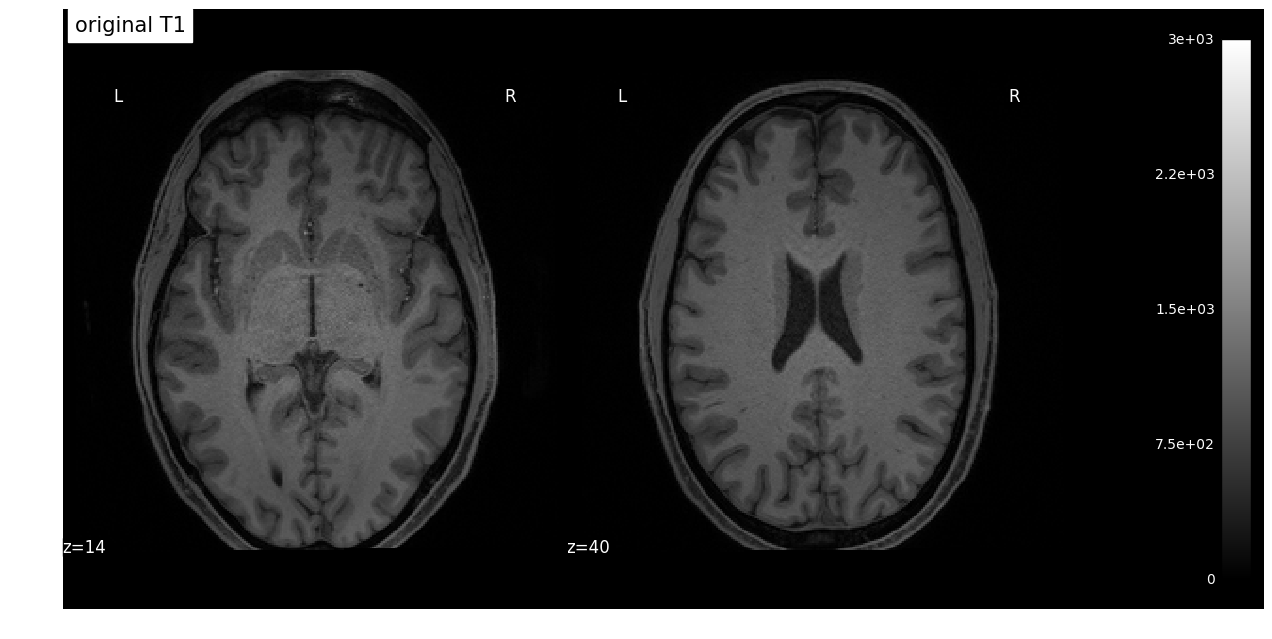

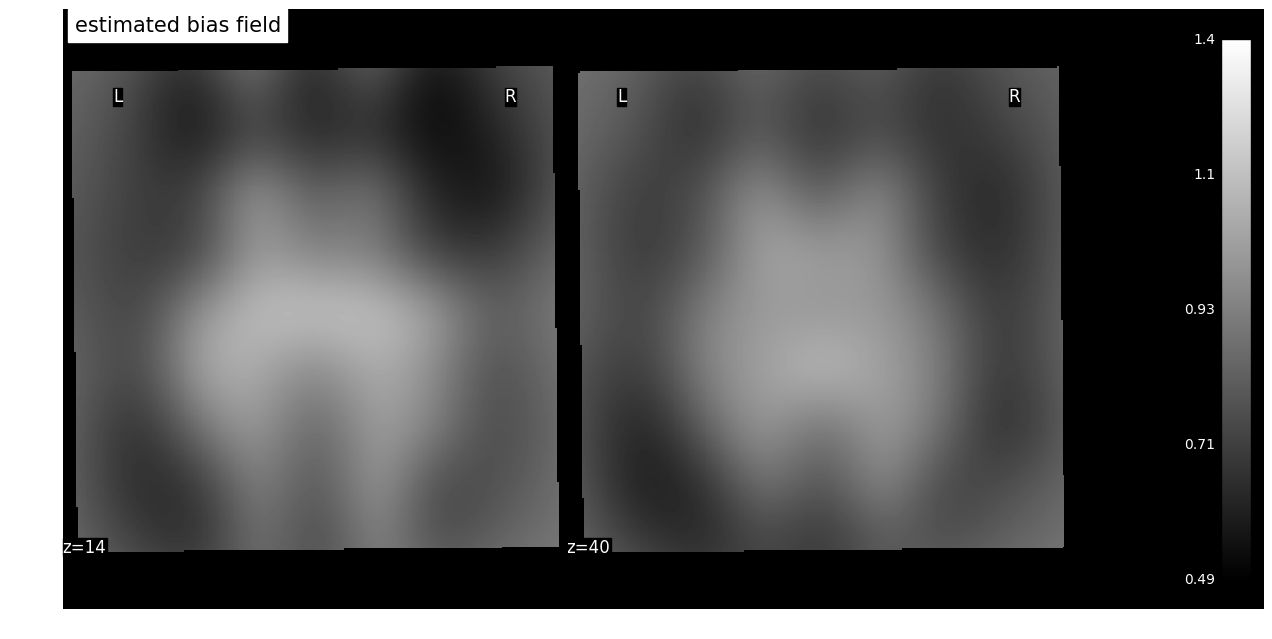

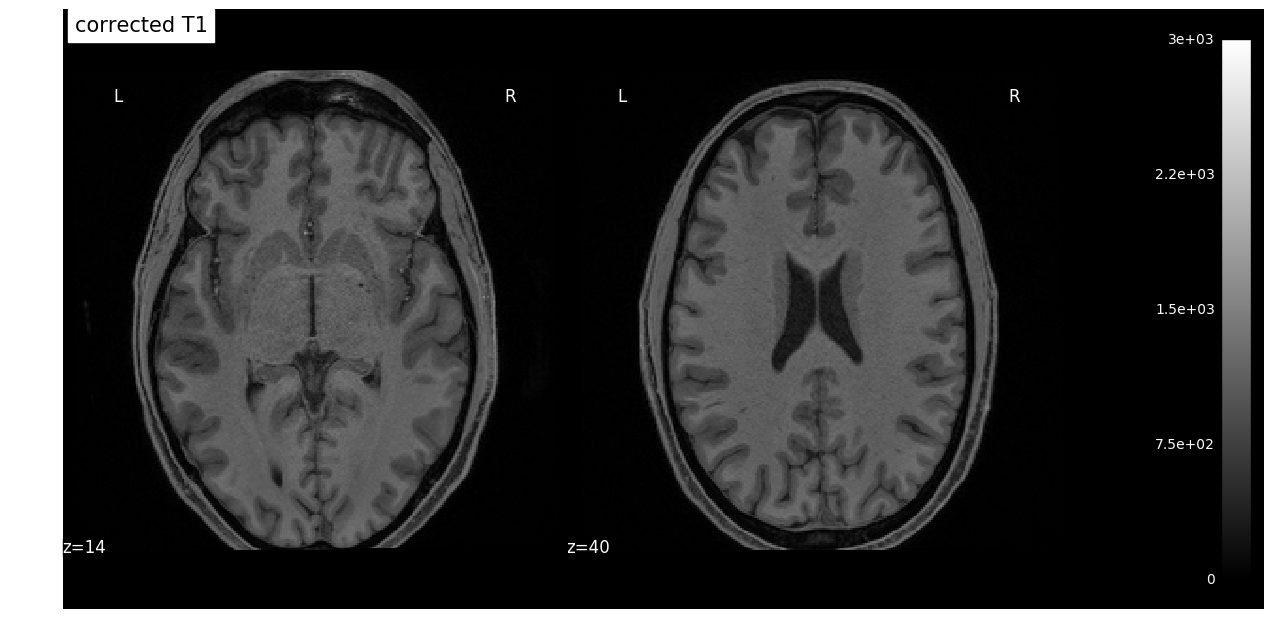

In [6]:
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(t1file, colorbar=True, vmax=3000, display_mode='z', cut_coords=(14, 40), 
                           title="original T1", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correcton_results.outputs.bias_image, display_mode='z', 
                          cut_coords=(14, 40), colorbar=True, title="estimated bias field", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correcton_results.outputs.output_image, colorbar=True, 
                           vmax=3000, display_mode='z', cut_coords=(14, 40), title="corrected T1", figure=fig)

__Exercise__: Compute the difference between the original and bias-corrected image, and display the difference in the same two slices as above.

## Brain extraction using BET

In [7]:
bet = mem.cache(fsl.BET)
bet_results = bet(in_file=bias_field_correcton_results.outputs.output_image,
                  mask=True,
                  frac=0.3)
bet_results.outputs

161012-20:51:34,521 workflow INFO:
	 Executing node b759e86642ba486166bb7bcbfeca4cbf in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/b759e86642ba486166bb7bcbfeca4cbf
161012-20:51:34,524 workflow INFO:



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/b759e86642ba486166bb7bcbfeca4cbf/sub00001_ses018_T1w_001_corrected_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/b759e86642ba486166bb7bcbfeca4cbf/sub00001_ses018_T1w_001_corrected_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

Visualize brain mask overlaid on anatomy

/home/vagrant/miniconda3/lib/python3.5/site-packages/nilearn/image/resampling.py:472: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/vagrant/miniconda3/lib/python3.5/site-packages/nilearn/image/resampling.py:472: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


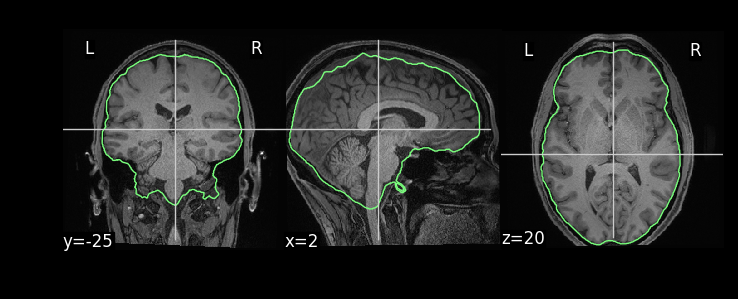

In [7]:
mask_display=nilearn.plotting.plot_epi(t1file,cmap='gray')
mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5]) 

## Combined corregistration and fieldmap unwarping using boundary based registration

Please note that we are using mean EPI image instead of whole time series.

In [12]:
# first need to prepare the fieldmap

fmp=mem.cache(fsl.PrepareFieldmap)
fmp_results=fmp(in_phase=fmapphasediff,
               in_magnitude=fmapmagdiff,
               out_fieldmap=fmap)



161012-19:56:30,683 workflow INFO:
	 Executing node 7195642fa39cc3fc82493c1311d96dbf in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/7195642fa39cc3fc82493c1311d96dbf
161012-19:56:30,688 workflow INFO:
	 Running: fsl_prepare_fieldmap SIEMENS /home/vagrant/data/ds031/sub00001/ses014/fieldmap/sub00001_ses014_001_phasediff.nii.gz /home/vagrant/data/ds031/sub00001/ses014/fieldmap/sub00001_ses014_001_magdiff.nii.gz /home/vagrant/fmri-analysis-vm/analysis/results/fieldmap.nii.gz 2.460000
161012-19:56:31,735 interface INFO:
	 stdout 2016-10-12T19:56:31.735883:Loading volumes
161012-19:56:31,737 interface INFO:
	 stdout 2016-10-12T19:56:31.735883:Phase loaded
161012-19:56:31,738 interface INFO:
	 stdout 2016-10-12T19:56:31.735883:Magnitude loaded
161012-19:56:31,739 interface INFO:
	 stdout 2016-10-12T19:56:31.735883:Mask loaded
161012-19:56:31,740 interface INFO:
	 stdout 2016-10-12T19:56:31.735883:Rewrapping phase range to [-p

KeyboardInterrupt: 

In [10]:
fmmean=mem.cache(fsl.MeanImage)
fmmean_results=fmmean(in_file=fmapmag)

fmbet=mem.cache(fsl.BET)
fmbet_results=fmbet(in_file=fmmean_results.outputs.out_file,
                   out_file=fmapmagbrain)


mcflirt = mem.cache(fsl.MCFLIRT)
mcflirt_results = mcflirt(in_file=boldfile,
                          mean_vol=True)

boldbet = mem.cache(fsl.BET)
bet_results = boldbet(functional=True,
              in_file=mcflirt_results.outputs.mean_img,
              mask=True)

161012-20:53:04,517 workflow INFO:
	 Executing node 93635f8354bcd886e884e26f20008609 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-maths-MeanImage/93635f8354bcd886e884e26f20008609
161012-20:53:04,518 workflow INFO:
161012-20:53:04,528 workflow INFO:
	 Executing node 6033b05365e3efe9f47869ad7af44f9b in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/6033b05365e3efe9f47869ad7af44f9b
161012-20:53:04,531 workflow INFO:
161012-20:53:04,540 workflow INFO:
	 Executing node fbfa00c218746e802e49f0bde8aa0174 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/fbfa00c218746e802e49f0bde8aa0174
161012-20:53:04,547 workflow INFO:
	 Running: mcflirt -in /home/vagrant/data/ds031/sub00001/ses014/functional/sub00001_ses014_task002_run001_bold.nii.gz -meanvol -out /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-in

In [11]:
epi_reg = mem.cache(fsl.EpiReg)
epi_reg_results = epi_reg(epi=bet_results.outputs.out_file,
                          t1_head=bias_field_correcton_results.outputs.output_image,
                          t1_brain=bet_results.outputs.out_file,
                          fmap=fmap,
                          fmapmag=fmapmag,
                          fmapmagbrain=fmapmagbrain,
                          echospacing=2.6/10000.0,
                          pedir='y',
                          out_base="epi2struct")
force_symlink(epi_reg_results.outputs.fullwarp, os.path.join(results_dir, "epi_to_t1_warp.nii.gz"))
epi_reg_results.outputs

161012-20:56:03,239 workflow INFO:
	 Executing node 8aa1a7a3a91b013599dd0026e9a31d4e in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/8aa1a7a3a91b013599dd0026e9a31d4e
161012-20:56:03,244 workflow INFO:
	 Running: epi_reg --echospacing=0.000260 --fmap=/home/vagrant/fmri-analysis-vm/analysis/results/fieldmap.nii.gz --fmapmag=/home/vagrant/data/ds031/sub00001/ses014/fieldmap/sub00001_ses014_001_magnitude.nii.gz --fmapmagbrain=/home/vagrant/fmri-analysis-vm/analysis/results/fmapmagbrain.nii.gz --noclean --pedir=y --epi=/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/fe668b7077efc12dc17112fa1290615d/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain.nii.gz --t1=/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/0ee99ba1bb2c1fe9f082ea94b809ecd0/sub00001_ses018_T1w_001_corrected.nii.gz --t1brain=/home/


epi2str_inv = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/8aa1a7a3a91b013599dd0026e9a31d4e/epi2struct_inv.mat
epi2str_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/8aa1a7a3a91b013599dd0026e9a31d4e/epi2struct.mat
fmap2epi_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/8aa1a7a3a91b013599dd0026e9a31d4e/epi2struct_fieldmaprads2epi.mat
fmap2str_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/8aa1a7a3a91b013599dd0026e9a31d4e/epi2struct_fieldmap2str.mat
fmap_epi = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/8aa1a7a3a91b013599dd0026e9a31d4e/epi2struct_fieldmaprads2epi.nii.gz
fmap_str = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/8aa1a7a3a91b013599dd0026e9a31d4e/epi2

Boundary based registration used grey/white matter interface to corregister EPI and T1 images. This boundary has been estimated from the T1 image.

/home/vagrant/miniconda3/lib/python3.5/site-packages/nilearn/image/resampling.py:472: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


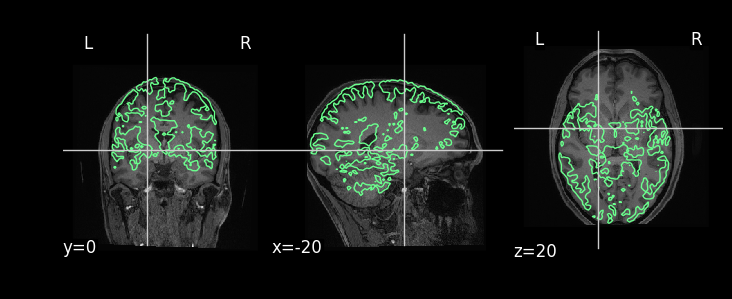

In [15]:
mask_display=nilearn.plotting.plot_epi(t1file,cmap='gray', cut_coords=(-20,0,20))
mask_display.add_contours(epi_reg_results.outputs.wmseg, levels=[.5]) 

To evaluate the quality of the corregistration lets overlay the grey-white matter border on top of the EPI image.

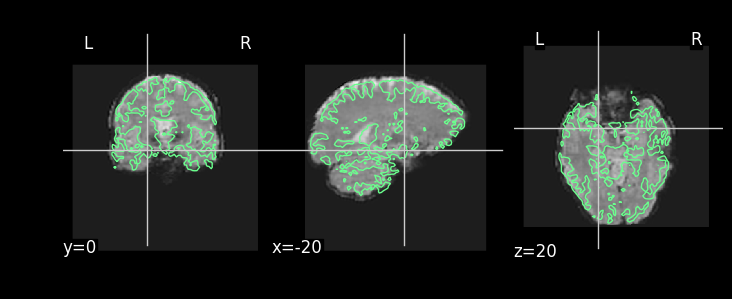

In [13]:
mask_display=nilearn.plotting.plot_epi(epi_reg_results.outputs.out_file,cmap='gray', cut_coords=(-20,0,20))
mask_display.add_contours(epi_reg_results.outputs.wmseg, levels=[.5]) 

## Normalization (T1 to MNI corregistration) using ANTs

To save time we will reduce the number of iterations.

In [14]:
ants_reg = mem.cache(ants.Registration)
ants_results = ants_reg(fixed_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                    moving_image = bet_results.outputs.out_file,
                    transforms = ['Translation', 'Rigid', 'Affine', 'SyN'],
                    transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)],
                    #number_of_iterations = ([[10000, 111110, 11110]]*3 +
                    #                [[100, 50, 30]]),
                    number_of_iterations = ([[10, 10, 10]]*3 +
                                    [[1, 5, 3]]),
                    dimension = 3,
                    write_composite_transform = True,
                    metric = ['Mattes'] * 3 + [['Mattes', 'CC']],
                    metric_weight = [1] * 3 + [[0.5, 0.5]],
                    radius_or_number_of_bins = [32] * 3 + [[32, 4]],
                    sampling_strategy = ['Regular'] * 3 + [[None, None]],
                    sampling_percentage = [0.3] * 3 + [[None, None]],
                    convergence_threshold = [1.e-8] * 3 + [-0.01],
                    convergence_window_size = [20] * 3 + [5],
                    smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]],
                    sigma_units = ['vox'] * 4,
                    shrink_factors = [[6, 4, 2]] + [[3, 2, 1]]*2 + [[4, 2, 1]],
                    use_estimate_learning_rate_once = [True] * 4,
                    use_histogram_matching = [False] * 3 + [True],
                    initial_moving_transform_com = True,
                    output_warped_image = True)
force_symlink(ants_results.outputs.composite_transform, os.path.join(results_dir, "t1_to_mni_warp.h5"))
ants_results.outputs

161012-21:03:33,277 workflow INFO:
	 Executing node 71cf12fd00af0abd2f55c82d0f5ee549 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/71cf12fd00af0abd2f55c82d0f5ee549
161012-21:03:33,292 workflow INFO:
	 Running: antsRegistration --collapse-output-transforms 0 --dimensionality 3 --initial-moving-transform [ /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz, /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/fe668b7077efc12dc17112fa1290615d/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain.nii.gz, 1 ] --initialize-transforms-per-stage 0 --interpolation Linear --output [ transform, transform_Warped.nii.gz ] --transform Translation[ 0.1 ] --metric Mattes[ /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz, /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/fe668b7077efc12dc17112fa129061

/home/vagrant/miniconda3/lib/python3.5/site-packages/nipype/interfaces/base.py:432: UserWarning: Input convergence_threshold requires inputs: number_of_iterations
  warn(msg)


161012-21:03:33,863 interface INFO:
	 stdout 2016-10-12T21:03:33.863177:All_Command_lines_OK
161012-21:03:33,864 interface INFO:
	 stdout 2016-10-12T21:03:33.863177:Using double precision for computations.
161012-21:03:33,864 interface INFO:
	 stdout 2016-10-12T21:03:33.863177:=============================================================================
161012-21:03:33,865 interface INFO:
	 stdout 2016-10-12T21:03:33.863177:The composite transform comprises the following transforms (in order): 
161012-21:03:33,865 interface INFO:
	 stdout 2016-10-12T21:03:33.863177:  1. Center of mass alignment using fixed image: /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz and moving image: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/fe668b7077efc12dc17112fa1290615d/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain.nii.gz (type = Euler3DTransform)
161012-21:03:33,866 interface INFO:
	 stdout 2016-10-12T21:03:33.863177


composite_transform = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/71cf12fd00af0abd2f55c82d0f5ee549/transformComposite.h5
forward_invert_flags = []
forward_transforms = []
inverse_composite_transform = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/71cf12fd00af0abd2f55c82d0f5ee549/transformInverseComposite.h5
inverse_warped_image = <undefined>
reverse_invert_flags = []
reverse_transforms = []
save_state = <undefined>
warped_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/71cf12fd00af0abd2f55c82d0f5ee549/transform_Warped.nii.gz

Lets plot the normalized subject brain next to the MNI template.

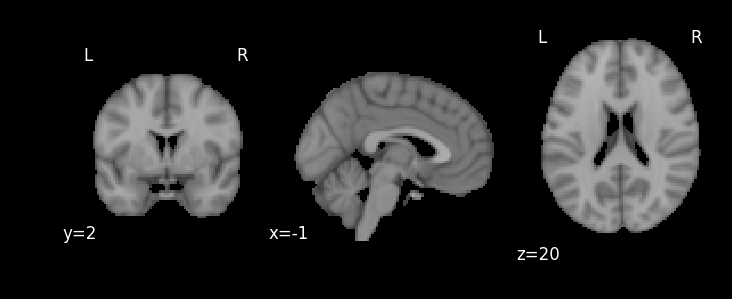

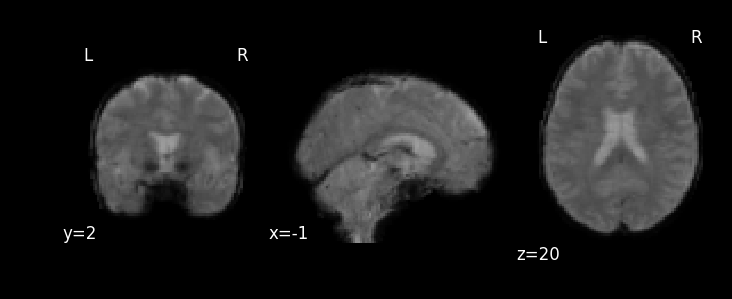

In [16]:
nilearn.plotting.plot_anat(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                           cut_coords=(-1,2,20), draw_cross=False)
nilearn.plotting.plot_anat(ants_results.outputs.warped_image,
                           cut_coords=(-1,2,20), draw_cross=False)

Again we can plot grey-white matter outline as an overlay to asses the quality of the corregistration. First we need to warp the WM segmentation file to the MNI space using just estimated transform

161012-21:07:55,814 workflow INFO:
	 Executing node fd430d60e7f373ed87b125e6af5166ca in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/fd430d60e7f373ed87b125e6af5166ca
161012-21:07:55,820 workflow INFO:
	 Running: antsApplyTransforms --default-value 0 --input /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/8aa1a7a3a91b013599dd0026e9a31d4e/epi2struct_fast_wmseg.nii.gz --interpolation NearestNeighbor --output epi2struct_fast_wmseg_trans.nii.gz --reference-image /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz --transform /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/71cf12fd00af0abd2f55c82d0f5ee549/transformComposite.h5
161012-21:07:56,378 interface INFO:
	 stdout 2016-10-12T21:07:56.378534:Using double precision for computations.
161012-21:07:56,380 interface INFO:
	 stdout 2016-10-12T21:

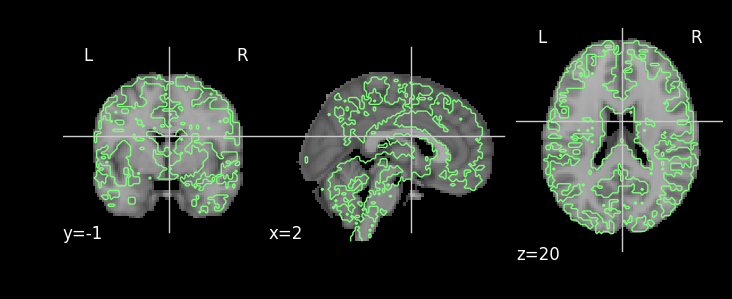

In [17]:
T1_to_MNI_warp = mem.cache(ants.ApplyTransforms)
T1wm_to_MNI_warp_results = T1_to_MNI_warp(input_image = epi_reg_results.outputs.wmseg,
                                          reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                          interpolation = "NearestNeighbor",
                                          transforms = ants_results.outputs.composite_transform)

fig = nilearn.plotting.plot_anat(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
fig.add_contours(T1wm_to_MNI_warp_results.outputs.output_image, levels=[.5]) 

Note that we have not yet combined the two transformations. We will do that when it comes to group level analysis. We will apply the combined transformations to single subject (first level) contrast maps.

We can test this procedure on the mean EPI image

In [19]:
epi_to_t1 = mem.cache(fsl.ApplyWarp)
epi_to_t1_results = epi_to_t1(in_file=mcflirt_results.outputs.mean_img,
                              ref_file=t1file,
                              field_file=epi_reg_results.outputs.fullwarp,
                              interp="spline")

t1_to_mni = mem.cache(ants.ApplyTransforms)
t1_to_mni_results = t1_to_mni(input_image=epi_to_t1_results.outputs.out_file,
                              reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                              transforms=ants_results.outputs.composite_transform,
                              interpolation="BSpline")
t1_to_mni_results.outputs

161012-21:09:26,357 workflow INFO:
	 Executing node 4f3ff33f3c52dd0c5814b62ea35a8a94 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/4f3ff33f3c52dd0c5814b62ea35a8a94
161012-21:09:26,362 workflow INFO:
	 Running: applywarp --in=/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/fbfa00c218746e802e49f0bde8aa0174/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg.nii.gz --ref=/home/vagrant/data/ds031/sub00001/ses018/anatomy/sub00001_ses018_T1w_001.nii.gz --out=/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/4f3ff33f3c52dd0c5814b62ea35a8a94/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_warp.nii.gz --warp=/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/8aa1a7a3a91b013599dd0026e9a31d4e/epi2struct_warp.nii.gz --interp=spline
161012-21:09:44,810 workf


output_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/6d006c8fd9579ba7cd3af98ef449c1f1/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_warp_trans.nii.gz

Now let's look at the warp field from ANTS

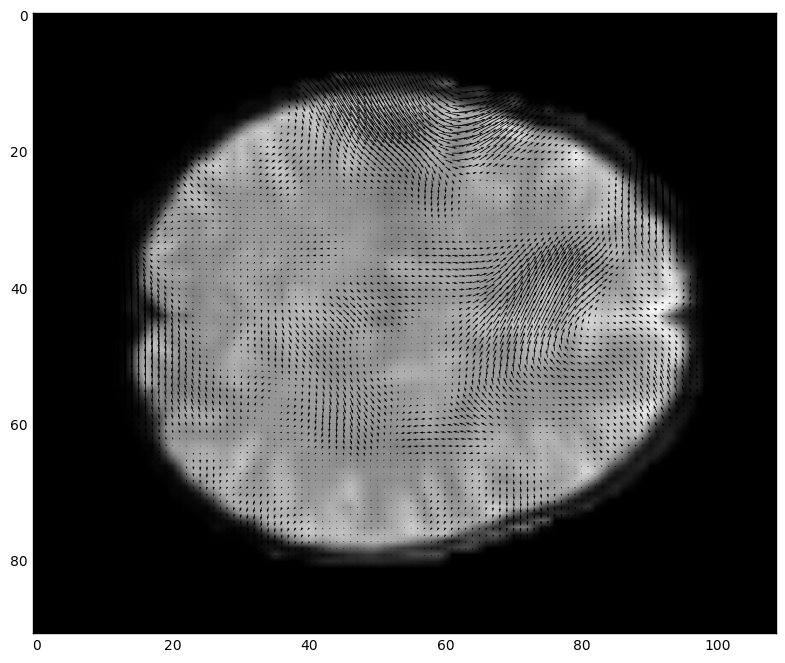

In [20]:
import h5py
composite_transform=h5py.File(ants_results.outputs.composite_transform,  "r")
transform_group=composite_transform['TransformGroup']
warpfield=numpy.reshape(transform_group['5']['TranformParameters'],(91,109,91,3))

warped_t1=nibabel.load(ants_results.outputs.warped_image)
warped_t1_data=warped_t1.get_data()
slicenum=50
plt.figure(figsize=(12,8))
plt.imshow(warped_t1_data[:,:,slicenum],cmap='gray')
plt.quiver(warpfield[:,:,slicenum,0],warpfield[:,:,slicenum,1],linewidths=0.001,width=0.001)

__Exercise__: Zoom into a part of the image and show a close-up of the warp field around the anterior cingulate cortex.



Finally we can interactivelly interrogate the three images (EPI, T1, MNI tempalate) in fslview

In [21]:
!fslview {t1_to_mni_results.outputs.output_image} {os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz')} {ants_results.outputs.warped_image}